<a href="https://colab.research.google.com/github/AL-NFLY/thesis-project-mcrs/blob/main/CF_MCRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA4015 - Recommender System - Assignment 3

The following assignment for CA4015 covers recommender systems and starts out with a basic implementation based on matrix factorization.

Section 1 - The Dataset

+ 1.1 - Reading in the data
+ 1.2 - Data cleaning
+ 1.3 - Data exploration

Section 2 - Recommender System Models

+ 2.1 - Data transformation
+ 2.2 - Matrix Factorization

+ 2.7 - Conclusion

Section 3 - New User Recommendations

Section 4 - Conclusion

---
# 1. READING DATA
---



## 1.1 Importing Necessary Libraries
---

I will also import the libraries that I'm going to need in this section.

In [ ]:
# !pip install spotipy

In [ ]:
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
from google.colab import drive
# Mount my drive at the following location
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import os
import ast
import sys
import glob
import string
import nltk


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import plotly as ply
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# import umap

from tqdm.auto import tqdm

from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 Reading in Dataset
---


Now I can start to read in the data. When reading in the tag data I was returned a decoding error, as the default utf-8 was not able to decode the data. After some Googling and trial-and-error, I have found that the basic encoding iso-8859-1, also known as latin-1, seems to do the trick for these files.

In [ ]:
# user_artists = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/user_artists.dat", sep="\t", encoding='utf-8')
# artists = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/artists.dat", sep='\t', encoding='utf-8')
# tags = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/tags.dat", sep="\t", encoding='latin-1')
# user_friends = pd.read_csv('drive/MyDrive/CA4015/dataset/raw/user_friends.dat', sep='\t', encoding='latin-1')
# tagged_timestamp = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/user_taggedartists-timestamps.dat", sep="\t", encoding='latin-1')

# # chage time in user)tags table to a timestamp
# tagged_timestamp['timestamp'] = pd.to_datetime(tagged_timestamp['timestamp'], unit='ms')

In [ ]:
user_artists = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/user_artists.dat", sep="\t", encoding='latin-1')
artists = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/artists.dat", sep='\t', encoding='latin-1')
tags = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/tags.dat", sep="\t", encoding='latin-1')
user_friends = pd.read_csv('drive/MyDrive/CA4015/dataset/raw/user_friends.dat', sep='\t', encoding='latin-1')
tagged_timestamp = pd.read_csv("drive/MyDrive/CA4015/dataset/raw/user_taggedartists-timestamps.dat", sep="\t", encoding='latin-1')

# chage time in user)tags table to a timestamp
tagged_timestamp['timestamp'] = pd.to_datetime(tagged_timestamp['timestamp'], unit='ms')

In [ ]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [ ]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [ ]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [ ]:
tagged_timestamp.head()

,userID,artistID,tagID,timestamp
0,2,52,13,2009-03-31 22:00:00
1,2,52,15,2009-03-31 22:00:00
2,2,52,18,2009-03-31 22:00:00
3,2,52,21,2009-03-31 22:00:00
4,2,52,41,2009-03-31 22:00:00


In [ ]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


## 1.2 Checking for Missing Data in Dataframes
---

In [ ]:
dfs = [user_artists, artists, tags, tagged_timestamp, user_friends]

In [ ]:
for df in dfs:
  print(df.isnull().values.any())

False
True
False
False
False


It seems that our artist dataframe has nulls present. Let us dive further into this and invertigate these nulls.

In [ ]:
artists.isnull().any()

id            False
name          False
url           False
pictureURL     True
dtype: bool

In [ ]:
artists[artists.isnull().any(axis=1)]

,id,name,url,pictureURL
105,111,Pleq & Anna Rose Carter,http://www.last.fm/music/+noredirect/Pleq%2B%2...,NaN
113,119,billy gomberg + offthesky,http://www.last.fm/music/+noredirect/billy%2Bg...,NaN
118,124,Shinkei & Mise En Scene,http://www.last.fm/music/Shinkei%2B%2526%2BMis...,NaN
127,133,Lauki,http://www.last.fm/music/Lauki,NaN
392,398,www.DjFahad.com,http://www.last.fm/music/www.DjFahad.com,NaN
...,...,...,...,...
17504,18601,uwe hÃ¼bner-der deutsche hitmix,http://www.last.fm/music/uwe+h%C3%BCbner-der+d...,NaN
17525,18622,Pete Hopkins,http://www.last.fm/music/Pete+Hopkins,NaN
17542,18646,shaggy and big yard crew,http://www.last.fm/music/shaggy+and+big+yard+crew,NaN
17544,18648,Ramin Djawadi And The RZA,http://www.last.fm/music/Ramin+Djawadi+And+The...,NaN


## 1.3 Implementing SpotifyAPI
---

In [ ]:
# Create client
spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id= '<insert id>',
    client_secret='<insert secret>'
))

NameError: ignored

In [ ]:
def get_artist_info(name):
    # Get respon dari Spotify API
    results = spotify.search(q=f'artist:{name}', type='artist')

    spotify_name = name
    genres = []
    img_url = None
    spotify_url = None

    if len(results['artists']['items']) > 0:
        # Sort the returned results based on how close they are to the query name.
        items = sorted(results['artists']['items'], key=(lambda x: nltk.edit_distance(name.lower(), x["name"].lower())))

        # Sort results by popularity
        #items = sorted(results['artists']['items'], key=(lambda x: x["popularity"]), reverse=True)

        if len(items) > 0:
            artist = items[0]

            # assign variables
            genres = artist['genres']
            spotify_name = artist['name']
            spotify_url = artist['external_urls']['spotify']

            # assign image url
            image_list = artist['images']
            if len(image_list) > 0:
                img_url = image_list[0]['url']

    return spotify_name, genres, img_url, spotify_url

In [ ]:
spotify_data.head()

In [ ]:
spotify_data.to_csv('/content/drive/MyDrive/CA4015/dataset/processed/spotify_data.csv', index=False)

In [ ]:
spotify_data = pd.read_csv('/content/drive/MyDrive/CA4015/dataset/processed/spotify_data.csv')
spotify_data.head()

We can see that the only nulls are in the pictureURL column, which is not an important feature for making predictions, which is lucky as this is not a value we can impute. If this value was needed, the solution would possibly be to webscrape Last.FM to find the URL for a page relating to an artist.

In [ ]:
spotify_data

## 1.4 Merging Both Datasets into One
---

In [ ]:
spotify_data = pd.read_csv('/content/drive/MyDrive/CA4015/dataset/processed/spotify_data.csv')
spotify_data.head()

,name,genres,imageUrl,spotifyUrl
0,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
1,Morcheeba,"['downtempo', 'electronica', 'trip hop']",https://i.scdn.co/image/ab6761610000e5eb36946a...,https://open.spotify.com/artist/6bWxFw65IEJzBY...
2,Air,"['ambient pop', 'downtempo', 'electronica', 'i...",https://i.scdn.co/image/ab6761610000e5ebb3f06b...,https://open.spotify.com/artist/1P6U1dCeHxPui5...
3,Hooverphonic,"['downtempo', 'electronica', 'trip hop']",https://i.scdn.co/image/ab6761610000e5eb1f66a2...,https://open.spotify.com/artist/5EP020iZcwBqHR...
4,Kylie Minogue,"['australian dance', 'australian pop', 'dance ...",https://i.scdn.co/image/ab6761610000e5eb8fba8b...,https://open.spotify.com/artist/4RVnAU35WRWra6...


In [ ]:
# Rename the id column in artists to artistID to make merge less verbose and more clear.
artists.rename({"id": "artistID"}, axis=1, inplace=True)

In [ ]:
# with spotify tag
full_user_artists = pd.merge(user_artists, artists, on='artistID').merge(spotify_data, on="name").drop(['url', 'pictureURL'], axis=1)
full_user_artists

,userID,artistID,weight,name,genres,imageUrl,spotifyUrl
0,2,51,13883,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
1,4,51,228,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
2,27,51,85,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
3,28,51,10,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
4,62,51,528,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
...,...,...,...,...,...,...,...
92829,2100,18726,337,Nyktalgia,[],NaN,NaN
92830,2100,18727,297,Atsakau niekadA,[],NaN,NaN
92831,2100,18728,281,Domantas Razauskas,"['dainuojamoji poezija', 'lithuanian pop', 'su...",https://i.scdn.co/image/ab67616d0000b27319d5ed...,https://open.spotify.com/artist/54NzaGyqx8dZXS...
92832,2100,18729,280,Atalyja,"['baltic folk', 'lithuanian folk']",https://i.scdn.co/image/ab67616d0000b2735d94d0...,https://open.spotify.com/artist/26HpF3x2OMGGsn...


In [ ]:
# # with lastfm tag
# full_user_artists = pd.merge(user_artists, artists, on="artistID").merge(spotify_data, on="name").drop(['url', 'pictureURL'], axis=1)
# full_user_artists

With a quich sanity check we can see that there are ~92,800 records which matches the description of the dataset.

Now we can join the tags data

In [ ]:
tags_timestamp = pd.merge(tags, tagged_timestamp, on="tagID")
tags_timestamp.head()

,tagID,tagValue,userID,artistID,timestamp
0,1,metal,4,918,2008-04-30 22:00:00
1,1,metal,12,181,2010-04-30 22:00:00
2,1,metal,12,198,2010-01-31 23:00:00
3,1,metal,12,500,2010-01-31 23:00:00
4,1,metal,12,503,2010-02-28 23:00:00


In [ ]:
assert tagged_timestamp.shape[0] == tags_timestamp.shape[0]

In [ ]:
full_user_artists.to_csv('/content/drive/MyDrive/CA4015/dataset/processed/full_user_artists.csv', index=False)
tags_timestamp.to_csv('/content/drive/MyDrive/CA4015/dataset/processed/tags_timestamp.csv', index=False)

In [ ]:
test_df = full_user_artists.drop_duplicates(subset=['artistID'])
test_df

,userID,artistID,weight,name,genres,imageUrl,spotifyUrl
0,2,51,13883,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
111,2,52,11690,Morcheeba,"['downtempo', 'electronica', 'trip hop']",https://i.scdn.co/image/ab6761610000e5eb36946a...,https://open.spotify.com/artist/6bWxFw65IEJzBY...
134,2,53,11351,Air,"['ambient pop', 'downtempo', 'electronica', 'i...",https://i.scdn.co/image/ab6761610000e5ebb3f06b...,https://open.spotify.com/artist/1P6U1dCeHxPui5...
209,2,54,10300,Hooverphonic,"['downtempo', 'electronica', 'trip hop']",https://i.scdn.co/image/ab6761610000e5eb1f66a2...,https://open.spotify.com/artist/5EP020iZcwBqHR...
227,2,55,8983,Kylie Minogue,"['australian dance', 'australian pop', 'dance ...",https://i.scdn.co/image/ab6761610000e5eb8fba8b...,https://open.spotify.com/artist/4RVnAU35WRWra6...
...,...,...,...,...,...,...,...
92829,2100,18726,337,Nyktalgia,[],NaN,NaN
92830,2100,18727,297,Atsakau niekadA,[],NaN,NaN
92831,2100,18728,281,Domantas Razauskas,"['dainuojamoji poezija', 'lithuanian pop', 'su...",https://i.scdn.co/image/ab67616d0000b27319d5ed...,https://open.spotify.com/artist/54NzaGyqx8dZXS...
92832,2100,18729,280,Atalyja,"['baltic folk', 'lithuanian folk']",https://i.scdn.co/image/ab67616d0000b2735d94d0...,https://open.spotify.com/artist/26HpF3x2OMGGsn...


After another sanity check, we can see that the number of rows has not changed after merging the data, which means we have not lost or gained any new records.

## 1.3 Data exploration

Now that we have joined some of the related data, we can take a look at the data and try to understand it with some more of an analysis. We will be taking a look at several features using exporatory visualisations.

+ The distribution of tag values and the most popular tags
+ User listens as a distribution and top users
+ Artist listens distribution and top artists
+ Distribution of friends per user

### Tags

In [ ]:
tag_count = tags_timestamp[['tagID', 'tagValue', 'userID']].groupby(by=['tagID', 'tagValue']).count()
tag_count = tag_count.rename({'userID': 'Count'}, axis=1).sort_values('Count', ascending=False).reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.barplot(x='Count', y='tagValue', data=tag_count[:15])

plt.title('Tag Terpopuler berdasarkan yang Diberikan User')
plt.ylabel('Tag / Genre Artis')
plt.xlabel('Jumlah User')
plt.show()

We can see that the top tags relate to music genres and then some very broad tags such as female vosalists and 80s which can apply to many tracks.

There is a steep drop after the first 6 tags, and by the 30th we are down to less than 1/7th of the top tag.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.lineplot(x=tag_count.index, y='Count', data=tag_count)

plt.title('Count untuk Tiap Tag dari Nilai Tertinggi')
plt.xlabel('Tag dalam Sorted List')
plt.ylabel('Count')
plt.show()

As we had seen when we looked at the top tags, there is a steep drop as we move down the sorted values. After roughly 250 tags it seems we are virtually at the floor.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
line_plot = sns.lineplot(x=tag_count.index, y='Count', data=tag_count)
line_plot.set(yscale='log')

plt.title('Count untuk Tiap Tag dari Nilai Tertinggi')
plt.xlabel('Tag dalam Sorted List')
plt.ylabel('Count')
plt.show()

Skala di atas adalah plot skala log yang berfungsi untuk melihat data yang divisualisasikan lebih teliti. Dilihat dari plot skala log dari data yang sama, dapat dilihat disekitar angka 1.500 pada daftar tag terulang kurang dari sepuluh kali. Di tag 4.250, tag hanya muncul sekali saja. Disimpulkan, tag diluar dari 2.000 tag pertama yang terpopuler bersifat under-represeted dalam data.

## 2.1 Users

In [ ]:
user_listens = full_user_artists[['userID', 'weight']].groupby(by=['userID']).sum()
user_listens = user_listens.sort_values('weight', ascending=False).rename({'weight': 'Total_listens'}, axis=1).reset_index()

In [ ]:
# Convert the userID to a string so we can use it for plotting as a name and not a value
user_listens['userID'] = user_listens['userID'].astype(str)

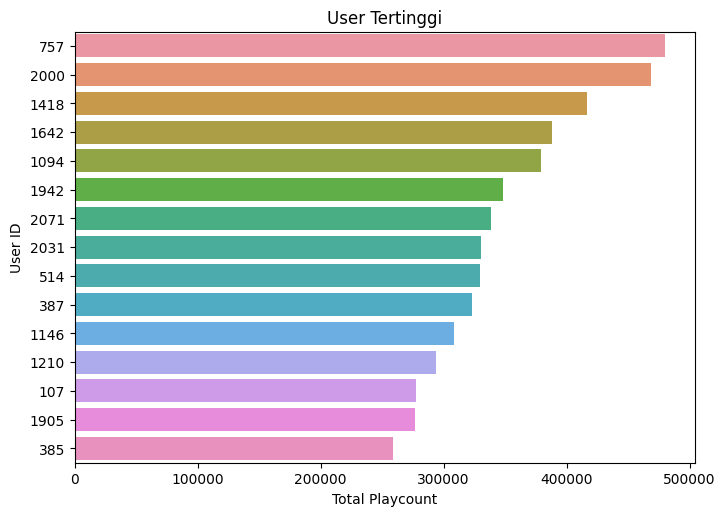

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.barplot(x='Total_listens', y='userID', data=user_listens[:15])

plt.title('User Tertinggi')
plt.xlabel('Total Playcount')
plt.ylabel('User ID')
plt.show()

Grafik di atas menunjukkan 25 user dengan playcount tertinggi dalam dataset. Terjadi penurunan drastis setelah lima user pertama di grafik. Pada bagian bawah grafik, user-user tersebut memiliki playcount yang jauh lebih rendah. Diprediksi hal serupa terjadi di bawah 25 user yang ditampilkan dalam grafik. Ini menunjukkan data terdistribusi dengan kecondongan ke kanan atau kecondongan positif, dimana sebagian besar titik data terkonsentrasi di bagian bawah distribusi.

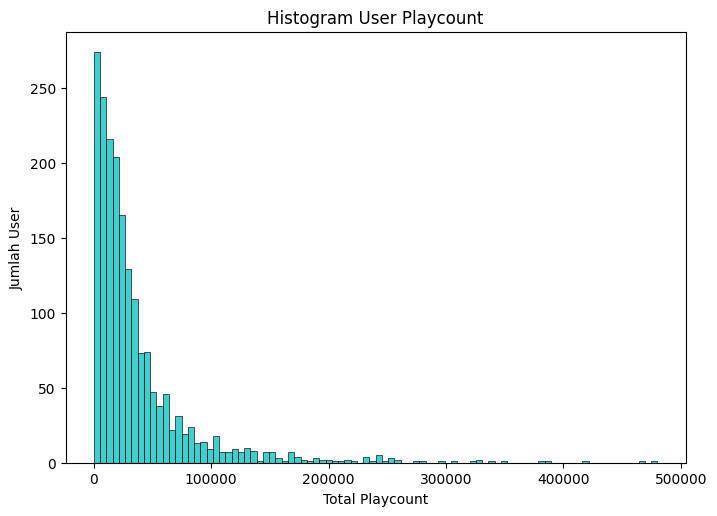

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.histplot(x='Total_listens', data=user_listens, color='c')

plt.title('Histogram User Playcount')
plt.xlabel('Total Playcount')
plt.ylabel('Jumlah User')
plt.show()

Grafik histogram di atas adalah data playcount dari semua user dalam dataset. Grafik ini memperjelas observasi terhadap grafik sebelumnya, bahwa terdapat perbedaan drastis dari user dengan playcount tertinggi dan user dengan playcount terendah. Sebagian besar user dari dataset memiliki kurang dari 100.000 playcount. Ini mengindikasikan tidak banyak user yang fanatik mendengarkan musik karena sebagian besar memiliki playcount yang relatif rendah.

Artists

In [ ]:
artist_listens = full_user_artists[['name', 'weight']].groupby(by=['name']).sum()
artist_listens = artist_listens.sort_values('weight', ascending=False).rename({'weight': 'Total_listens'}, axis=1).reset_index()

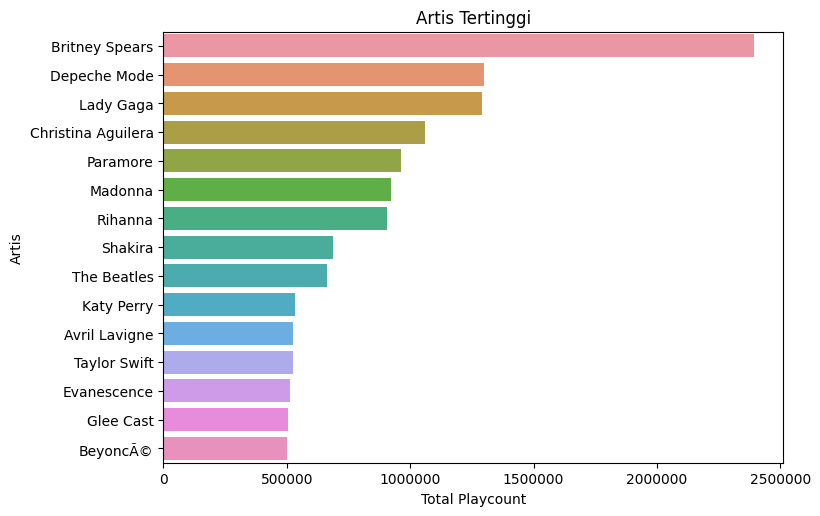

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.barplot(x='Total_listens', y='name', data=artist_listens[:15])

plt.ticklabel_format(style='plain', axis='x')
plt.title('Artis Tertinggi')
plt.xlabel('Total Playcount')
plt.ylabel('Artis')
plt.show()

Grafik barchart di atas menunjukkan artis-artis dengan playcount tertinggi dalam dataset. Dapat dilihat, Britney Spears merupakan artis paling populer dengan nilai playcount hampir dua kali lipat dibandingkan artis terpopuler selanjutnya. Artis tertinggi memiliki 2.4 juta playcount. Nilai playcount semakin turun drastis, semakin bawah posisi artis di grafik. Grafik kembali menunjukkan data terdistribusi positif.

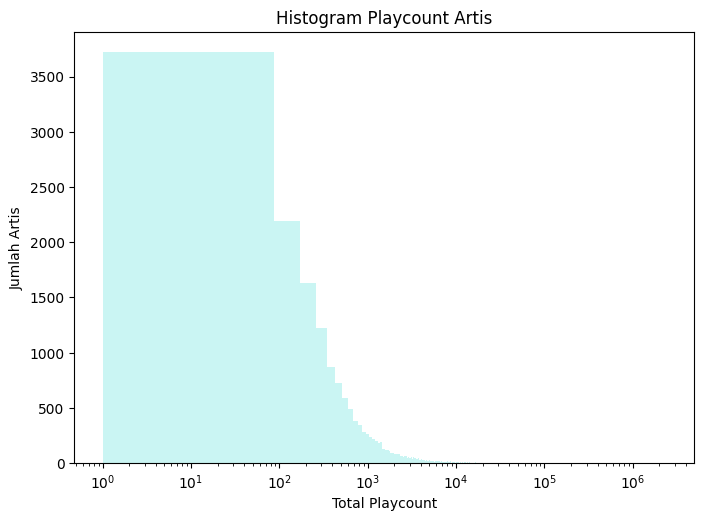

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.set_color_codes("pastel")
hist_plot = sns.histplot(x='Total_listens', data=artist_listens, color='c')
hist_plot.set(xscale='log')

plt.title('Histogram Playcount Artis')
plt.xlabel('Total Playcount')
plt.ylabel('Jumlah Artis')
plt.show()

Grafik histogram di atas menunjukkan total playcount terhadap semua artis pada dataset. Lebih dari 3.500 artis memiliki nilai playcount diantara nol hingga seratus. Melewati 10.000 playcount, tidak banyak artis yang berada pada grup ini. Walaupun grafik visualisasi telah bersifat log berskala, data masih terdistribusi dengan kecondongan ke kanan.

In [ ]:
user_friend_count = user_friends.groupby(by=['userID']).count()
user_friend_count = user_friends.rename({'friendID': 'Count'}, axis=1).sort_values('Count', ascending=False).reset_index()

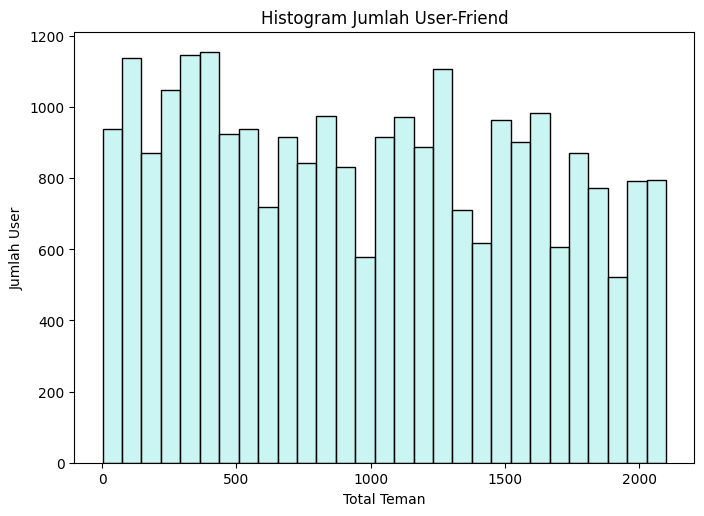

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5.6))
sns.histplot(x='userID', data=user_friend_count, color='c')

plt.title('Histogram Jumlah User-Friend')
plt.xlabel('Total Teman')
plt.ylabel('Jumlah User')
plt.show()

Untuk grafik terakhir, dibuat grafik yang menunjukkan hubungan antara user dengan teman user. Berdasarkan histogram di atas, para user dengan teman-teman user terdistribusikan dengan rata. Distribusi data user-friend dapat dianggap uniform distribution. Ini berarti setiap nilai dalam rentang memilik probabilitas yang konstan dan sama.

User friends

In [ ]:
user_friend_count = user_friends.groupby(by=["userID"]).count()
user_friend_count = user_friends.rename({"friendID": "Count"}, axis=1).sort_values("Count", ascending=False).reset_index()

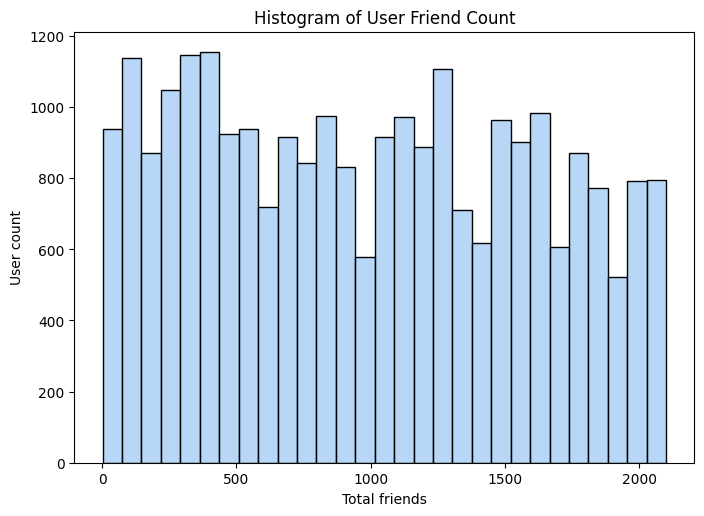

In [ ]:
f, ax = plt.subplots(figsize=(8, 5.6))

sns.set_color_codes("pastel")
sns.histplot(data=user_friend_count, x="userID", color="b")

plt.title("Histogram of User Friend Count")
plt.xlabel("Total friends")
plt.ylabel("User count")

plt.show()

It seems that the users are well distributed with regards to the number of friends they have. The distribution is not unsimilar to that of a uniform distribution.

Now that we have thoroughly looked at our data and how it is distributed, we can now look at creating our models.

# Section 2 - Recommender System Models

We will now look at making use of several models of varying difficult to create recommendations. These will be in increasing order of complexity. These models are based off of the tutorial provided by [Tensorflow for recommender systems](https://www.tensorflow.org/recommenders/examples/quickstart).

These models are as follows:

+ Collaborative filtering using matrix factorization
+ Basic ranking in Tensorflow
+ Using additional features
+ Custom implementation with user relations

These models are mostly pieces adapted from the tutorials with changes to fit this data, I will evaluate each and see if I can make improvements with my own theory in the last model.

## 2.1 Setup and Data transformation

Thus far we have not had to shift the IDs so they are contiguous, but this may be a good decision as matrix factorization uses these IDs along the columns of the user and item matrices.

We will only do this for matrix factorization and our later model will not need this. So we will just change this for the user and artist ID in the full_user_artists table and ignore occurences in the other data.

In [ ]:
ratings_table = full_user_artists.copy()
ratings_table

,userID,artistID,weight,name,genres,imageUrl,spotifyUrl
0,2,51,13883,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
1,4,51,228,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
2,27,51,85,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
3,28,51,10,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
4,62,51,528,Duran Duran,"['album rock', 'dance rock', 'new romantic', '...",https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...
...,...,...,...,...,...,...,...
92829,2100,18726,337,Nyktalgia,[],NaN,NaN
92830,2100,18727,297,Atsakau niekadA,[],NaN,NaN
92831,2100,18728,281,Domantas Razauskas,"['dainuojamoji poezija', 'lithuanian pop', 'su...",https://i.scdn.co/image/ab67616d0000b27319d5ed...,https://open.spotify.com/artist/54NzaGyqx8dZXS...
92832,2100,18729,280,Atalyja,"['baltic folk', 'lithuanian folk']",https://i.scdn.co/image/ab67616d0000b2735d94d0...,https://open.spotify.com/artist/26HpF3x2OMGGsn...


In [ ]:
# We can use np.unique(return_inverse=True) to get an array the same length as the input with the indexes
# of the first occurence of each unique value. Which is just what we need.
_, new_column = np.unique(ratings_table["userID"].values, return_inverse=True)
ratings_table["userID"] = new_column

In [ ]:
artists

,artistID,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [ ]:
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
old_column = ratings_table["artistID"].values
old_new_mapping = {k:v for k, v in zip(old_column, new_column)}

ratings_table["artistID"] = new_column
artists["artistID"] = artists["artistID"].apply(lambda x: old_new_mapping[x])

In [ ]:
print(set(old_new_mapping.keys()) - set(artists["artistID"]))

{18432, 18433, 18434, 18435, 18436, 18437, 18438, 18439, 18440, 18441, 18442, 18443, 18444, 18445, 18446, 18447, 18448, 18449, 18450, 18451, 18452, 18453, 18454, 18455, 18456, 18457, 18458, 18459, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18522, 18523, 18524, 18525, 18526, 18527, 18528, 18529, 18530, 18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539, 18540, 18541, 18542, 18543, 18544, 18545, 18546, 18547, 18548, 18549, 18550, 18551, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18561, 18562, 18563, 18564, 18571, 18572, 18573, 18574, 18575, 18576, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18584, 18585, 18586, 18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18599, 18600, 18601, 18602, 18603, 18604, 18605, 18606, 18607, 18608, 18609, 18610, 18611, 18612, 18613, 18614, 18615, 18616, 18617, 18618, 18619, 18620

In [ ]:
# Sanity check against the original
len(np.unique(full_user_artists["artistID"].values)) == len(np.unique(ratings_table["artistID"].values))

True

Next, we have multiple user-defined tags for each artist. In order the visualise these in a coherent way, it would be worth taking the most popular tag for each artist. In this way we are eliminating the unpopular and likely not relevant or valid tags in favour of the most accepted tag for an artist.

In [ ]:
ratings_table['genres'] = ratings_table['genres'].apply(ast.literal_eval)
ratings_table['Tag'] = ratings_table['genres'].apply(lambda x: x[0] if len(x) > 0 else None)
del ratings_table['genres']
ratings_table

,userID,artistID,weight,name,imageUrl,spotifyUrl,Tag
0,0,45,13883,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
1,2,45,228,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
2,24,45,85,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
3,25,45,10,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
4,59,45,528,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
...,...,...,...,...,...,...,...
92829,1891,17615,337,Nyktalgia,NaN,NaN,None
92830,1891,17616,297,Atsakau niekadA,NaN,NaN,None
92831,1891,17617,281,Domantas Razauskas,https://i.scdn.co/image/ab67616d0000b27319d5ed...,https://open.spotify.com/artist/54NzaGyqx8dZXS...,dainuojamoji poezija
92832,1891,17618,280,Atalyja,https://i.scdn.co/image/ab67616d0000b2735d94d0...,https://open.spotify.com/artist/26HpF3x2OMGGsn...,baltic folk


In [ ]:
# full_artist_info = pd.merge(artists, ratings_table, on=['artistID', 'name'], how='outer').drop_duplicates(subset=['artistID']).drop(['url', 'pictureURL', 'userID', 'weight'], axis=1).reset_index(drop=True)
# test = full_artist_info[['spotifyUrl', 'Tag']]
# test

In [ ]:
# artist_tag = {}

# # for every artist, count all their tags and take the most popular into our mapping
# for artist in tags_timestamp["artistID"].unique():
#   values, counts = np.unique(tags_timestamp[tags_timestamp["artistID"] == artist]["tagValue"].values, return_counts=True)
#   most_used = values[counts == counts.max()]
#   artist_tag[artist] = most_used[0]

In [ ]:
# def map_tags(value):
#   if value in artist_tag.keys():
#     return artist_tag[value]
#   else:
#     return "No Tag"

In [ ]:
# ratings_table["Tag"] = ratings_table.apply(lambda x: map_tags(x["artistID"]), axis=1)
# artists["Tag"] = artists.apply(lambda x: map_tags(x["artistID"]), axis=1)

In [ ]:
ratings_table

,userID,artistID,weight,name,imageUrl,spotifyUrl,Tag
0,0,45,13883,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
1,2,45,228,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
2,24,45,85,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
3,25,45,10,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
4,59,45,528,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock
...,...,...,...,...,...,...,...
92829,1891,17615,337,Nyktalgia,NaN,NaN,None
92830,1891,17616,297,Atsakau niekadA,NaN,NaN,None
92831,1891,17617,281,Domantas Razauskas,https://i.scdn.co/image/ab67616d0000b27319d5ed...,https://open.spotify.com/artist/54NzaGyqx8dZXS...,dainuojamoji poezija
92832,1891,17618,280,Atalyja,https://i.scdn.co/image/ab67616d0000b2735d94d0...,https://open.spotify.com/artist/26HpF3x2OMGGsn...,baltic folk


Lastly, we need to consider the rating, or in this case the implicit rating of listens. Here we have got a continuous attribute as opposed to the typical ordinal of a 1-5 rating. If we don't address this we may get recommendations that are highly weighted towards the high values in the matrix.

To fix this we will need to change these values to either be binary or to fit into some groupings that we decide. As fitting the data to these groupings or ranges will preserve some data relating to how much a user likes an artist I have opted for this appraoch.

The following is what I have decided:

+ 0 - A user has not listened to an artist
+ 1 - A user has listened to an artist once
+ 2 - A user has listened to an artist 2-1000 times
+ 3 - A user has listened to an artist 1001-10000 times
+ 4 - A user has listened to an artist 10001-50000 times
+ 5 - A user has listened to an artist 50000+ times

This should capture much of the data relative to a user liking a artist. If a user listens to an artist only once we can extrapolate that they didn't enjoy the listen.

In [ ]:
def listening_mapping(value):
  if value == 1:
    return 1
  elif value <= 1000:
    return 2
  elif value <= 10000:
    return 3
  elif value <= 50000:
    return 4
  else:
    return 5

In [ ]:
ratings_table["implicitRating"] = ratings_table.apply(lambda x: listening_mapping(x["weight"]), axis=1)

In [ ]:
for rating in range(5, 0, -1):
    count = ratings_table[ratings_table['implicitRating'] == rating].shape[0]
    print('Number of artists with', rating, 'implicit rating:', count)

Number of artists with 5 implicit rating: 62
Number of artists with 4 implicit rating: 568
Number of artists with 3 implicit rating: 13430
Number of artists with 2 implicit rating: 78138
Number of artists with 1 implicit rating: 636


In [ ]:
ratings_table[ratings_table["implicitRating"] == 5]

,userID,artistID,weight,name,imageUrl,spotifyUrl,Tag,implicitRating
32,400,45,61012,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,5
77,1103,45,103150,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,5
541,183,50,84980,Daft Punk,https://i.scdn.co/image/ab6761610000e5eba7bfd7...,https://open.spotify.com/artist/4tZwfgrHOc3mvq...,electro,5
1246,1213,59,78496,Coldplay,https://i.scdn.co/image/ab6761610000e5eb989ed0...,https://open.spotify.com/artist/4gzpq5DPGxSnKT...,permanent wave,5
2063,198,66,56884,Depeche Mode,https://i.scdn.co/image/ab6761610000e5ebaff13c...,https://open.spotify.com/artist/762310PdDnwsDx...,dance rock,5
...,...,...,...,...,...,...,...,...
38423,292,908,82773,Iron Maiden,https://i.scdn.co/image/ab6761610000e5eb6456e7...,https://open.spotify.com/artist/6mdiAmATAx73kd...,hard rock,5
49469,1802,1435,50559,Akon,https://i.scdn.co/image/ab6761610000e5eb5896fe...,https://open.spotify.com/artist/0z4gvV4rjIZ9wH...,dance pop,5
55867,1293,2029,60845,Sarah Brightman,https://i.scdn.co/image/ab6761610000e5ebce24d7...,https://open.spotify.com/artist/7Ead768rc4ShGx...,operatic pop,5
56953,879,2164,64223,50 Cent,https://i.scdn.co/image/dd031b9c5d1b6eba4a691c...,https://open.spotify.com/artist/3q7HBObVc0L8jN...,east coast hip hop,5


In [ ]:
ratings_table.drop(["weight"], axis=1, inplace=True)
ratings_table.to_csv('/content/drive/MyDrive/CA4015/dataset/processed/ratings_table.csv')
ratings_table
# # drop all urls as well
# ratings_table.drop(["imageUrl", "spotifyUrl"], axis=1, inplace=True)

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
0,0,45,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,4
1,2,45,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,2
2,24,45,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,2
3,25,45,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,2
4,59,45,Duran Duran,https://i.scdn.co/image/ab6761610000e5eb47f638...,https://open.spotify.com/artist/0lZoBs4Pzo7R89...,album rock,2
...,...,...,...,...,...,...,...
92829,1891,17615,Nyktalgia,NaN,NaN,None,2
92830,1891,17616,Atsakau niekadA,NaN,NaN,None,2
92831,1891,17617,Domantas Razauskas,https://i.scdn.co/image/ab67616d0000b27319d5ed...,https://open.spotify.com/artist/54NzaGyqx8dZXS...,dainuojamoji poezija,2
92832,1891,17618,Atalyja,https://i.scdn.co/image/ab67616d0000b2735d94d0...,https://open.spotify.com/artist/26HpF3x2OMGGsn...,baltic folk,2


In [ ]:
# artists_info = ratings_table.copy().drop(['userID', 'Tag'], axis=1).drop_duplicates(subset=['artistID']).sort_values(by='artistID').reset_index(drop=True)
artists_info = ratings_table.copy().drop(['userID', 'implicitRating'], axis=1).drop_duplicates(subset=['artistID']).sort_values(by='artistID').reset_index(drop=True)
# artists_info.to_csv('/content/drive/MyDrive/CA4015/dataset/processed/artists_info.csv')
artists_info

,artistID,name,imageUrl,spotifyUrl,Tag
0,0,MALICE MIZER,NaN,NaN,None
1,1,Diary of Dreams,https://i.scdn.co/image/ab6761610000e5eb332690...,https://open.spotify.com/artist/1tg5jMp8FFjVqj...,dark wave
2,2,Carpathian Forest,https://i.scdn.co/image/ab67616d0000b2736b4987...,https://open.spotify.com/artist/0sFntmE9T1tiF6...,black metal
3,3,Moi dix Mois,https://i.scdn.co/image/ab67616d0000b273bba816...,https://open.spotify.com/artist/0p127CcuzngV5R...,None
4,4,Bella Morte,https://i.scdn.co/image/ab6761610000e5eb9b15fc...,https://open.spotify.com/artist/2SyimynlSU0Oii...,corrosion
...,...,...,...,...,...
17627,17627,Diamanda GalÃ¡s,NaN,NaN,None
17628,17628,Aya RL,https://i.scdn.co/image/ab67616d0000b27327c22a...,https://open.spotify.com/artist/3qZ0S1nVG3Pcct...,polish post-punk
17629,17629,Coptic Rain,NaN,https://open.spotify.com/artist/3GrTeFVsVk1fKB...,None
17630,17630,Oz Alchemist,https://i.scdn.co/image/ab6761610000e5ebcbd754...,https://open.spotify.com/artist/7tt8Fc1yW2t9SC...,None


In [ ]:
tagsz = artists_info[['Tag']].values
tagsz

array([[None],
       ['dark wave'],
       ['black metal'],
       ...,
       [None],
       [None],
       ['classic polish pop']], dtype=object)

In [ ]:
# ratings_table.drop(["weight"], axis=1, inplace=True)
# ratings_table

Now that the IDs are shifted, the genre is set and we have out implicit rating values we can proceed with training a collaborative filtering model using the matrix factorization approach.

### Altair Setup

Altair is used for creating interactive visualisation in Colab

In [ ]:
# # Install Altair and activate its colab renderer.
# print("Installing Altair...")
# !pip install altair
# import altair as alt
# alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('colab')
# print("Done installing Altair.")

# # Install spreadsheets and import authentication module.
# USER_RATINGS = False
# !pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials

In [ ]:
# def item_embedding_norm(ratings, models):
#   """Visualizes the norm and number of ratings of the movie embeddings.
#   Args:
#     model: A MFModel object.
#   """
#   if not isinstance(models, list):
#     models = [models]
#   df = ratings[["name", "Tag", "implicitRating"]].groupby(by=["name", "Tag"]).count().rename({"implicitRating": "num_ratings"}, axis=1).reset_index()

#   charts = []
#   brush = alt.selection_interval()
#   for i, model in enumerate(models):
#     norm_key = 'norm'+str(i)
#     df[norm_key] = np.linalg.norm(model.embeddings["artistID"], axis=1)
#     nearest = alt.selection(
#         type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
#         empty='none')
#     base = alt.Chart().mark_circle().encode(
#         x='num_ratings',
#         y=norm_key,
#         color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
#     ).properties(
#         selection=nearest).add_selection(brush)
#     text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
#         x='num_ratings', y=norm_key,
#         text=alt.condition(nearest, 'name', alt.value('')))
#     charts.append(alt.layer(base, text))
#   return alt.hconcat(*charts, data=df)

# tag_filter = alt.selection_multi(fields=['Tag'])
# tag_chart = alt.Chart().mark_bar().encode(
#     x="count()",
#     y=alt.Y('Tag'),
#     color=alt.condition(
#         tag_filter,
#         alt.Color("Tag:N"),
#         alt.value('lightgray'))
# ).properties(height=600, selection=tag_filter)

# def visualize_item_embeddings(data, x, y):
#   nearest = alt.selection(
#       type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
#       empty='none')
#   base = alt.Chart().mark_circle().encode(
#       x=x,
#       y=y,
#       color=alt.condition(tag_filter, "Tag", alt.value("whitesmoke")),
#   ).properties(
#       width=600,
#       height=600,
#       selection=nearest)
#   text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
#       x=x,
#       y=y,
#       text=alt.condition(nearest, 'name', alt.value('')))
#   return alt.hconcat(alt.layer(base, text), tag_chart, data=data)

# def tsne_artist_embeddings(ratings, model):
#   """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
#   Args:
#     model: A MFModel object.
#   """
#   tsne = sklearn.manifold.TSNE(
#       n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
#       init='pca', verbose=True, n_iter=400)

#   print('Running t-SNE...')
#   V_proj = tsne.fit_transform(model.embeddings["artistID"])
#   ratings.loc[:,'x'] = V_proj[:, 0]
#   ratings.loc[:,'y'] = V_proj[:, 1]
#   return visualize_item_embeddings(ratings, 'x', 'y')

## 2.2 Matrix Factorization

We will import helper functions that were defined in the collaborative filtering tutorial to setup the model.

These can be stored in a .py file to save space here. The Altair functions have to be in the notebook as they use !pip and this cannot be ran through a .py file.

### 2.2.1 Creating Matrix Factorization Model

In [ ]:
from CFUtils import build_rating_sparse_tensor, split_dataframe, sparse_mean_square_error, build_model, CFModel, user_recommendations, compute_scores, artist_neighbors, gravity, build_regularized_model
import sklearn
import tensorflow.compat.v1 as tf
import plotly.colors as colors

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# template for recommendation bar chart
template = dict(
  layout=go.Layout(
    title=dict(
      x=0.5,
      xanchor="center"
    )
  )
)
# Generate a gradual color set
color_scale = colors.sequential.Agsunset

 iteration 1000: train_error=0.139255, test_error=1.079027

[{'train_error': 0.13925469, 'test_error': 1.0790273}]

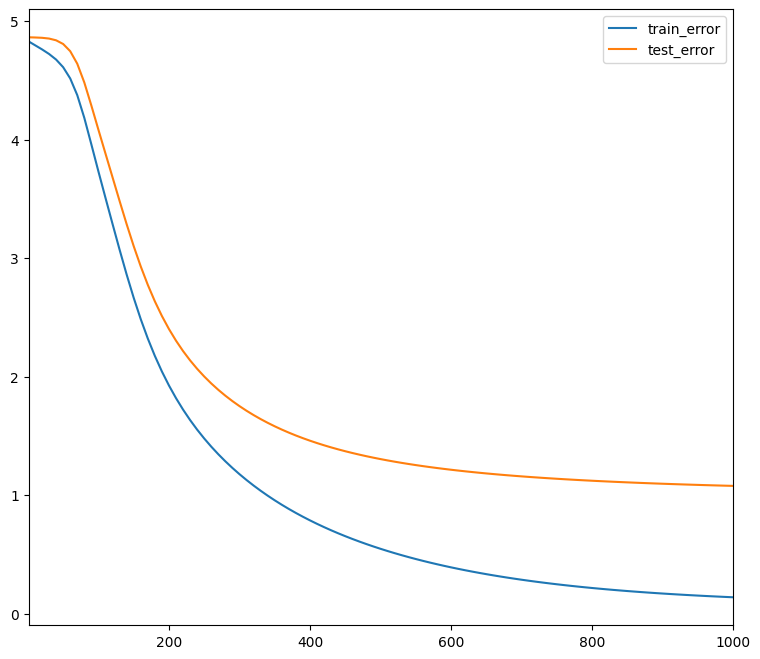

In [ ]:
# Pass our ratings to the model and train it
matrix_fac = build_model(ratings_table, embedding_dim=12, init_stddev=0.25)
matrix_fac.train(num_iterations=1000, learning_rate=10.)
# print(matrix_fac.train(num_iterations=101, learning_rate=10.))

We can see the train and test error above. It seems that the model is not improving anymore and more iterations would likely lead to overfitting.

As an initial test, we can compute the similarty between artists to find artists close to the artist in question. We will take a look at a few of these. We have two options for similarity measure, the dot product and cosine similarity. The dot product is likely to be more sensitive to a large norm than the cosine similarity.

Once the model is trained and the user and item representations are obtained, similarity measures like cosine similarity or dot product can be used to compute the similarity between users or items in the latent space. These similarity measures can be applied to recommend similar items to a given user or find similar users based on their preferences.

In [ ]:
rec_dot = artist_neighbors(matrix_fac, artists, "Muse", measure="dot", k=6)

fig_dot = go.Figure(
    data = go.Bar(dict(
        x = rec_dot['name'],
        y = rec_dot['dotScore'],
        marker=dict(
            color = color_scale
        ),
    )),
    layout = dict(
        template = template,
        xaxis = dict(title = 'Rekomendasi Artis', zeroline=True),
        yaxis = dict(title = 'Skor Dot', zeroline=True),
        title = dict(text = 'Rekomendasi Artis untuk User')
    )
)
fig_dot.show()

Nearest neighbors of : Muse.
[Found more than one matching artist. Other candidates: Dangerous Muse, Throwing Muses, Museum, Faith and the Muse, Museo Rosenbach]


,dotScore,name
5113,2.123,AndrÃ©s Calamaro
461,1.960,Darren Hayes
2820,1.954,Dashboard Confessional
184,1.942,Muse
364,1.919,Katatonia
3054,1.911,Jay Vaquer


In [ ]:
rec_cos = artist_neighbors(matrix_fac, artists, 'Lady Gaga', measure="cosine", k=6)

fig_cos = go.Figure(
    data = go.Bar(dict(
        x = rec_cos['name'],
        y = rec_cos['cosineScore'],
        marker=dict(
            color = color_scale
        ),
    )),
    layout = dict(
        template = template,
        xaxis = dict(title = 'Rekomendasi Artis', zeroline=True),
        yaxis = dict(title = 'Skor Cosine', zeroline=True),
        title = dict(text = 'Rekomendasi Artis untuk User')
    )
)
fig_cos.show()

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosineScore,name
83,1.000,Lady Gaga
898,0.976,Timbaland
460,0.973,Ke$ha
1438,0.973,Lady Antebellum
519,0.971,Gwen Stefani
300,0.967,Black Eyed Peas


In [ ]:
artist_neighbors(matrix_fac, artists, "The Beatles", measure="dot", k=6)
print('')

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,dotScore,name
5113,2.089,AndrÃ©s Calamaro
3054,2.032,Jay Vaquer
6460,2.031,Mae
221,1.988,The Beatles
10814,1.957,Uh Huh Her
433,1.952,Los Hermanos


In [ ]:
artist_neighbors(matrix_fac, artists, "The Beatles", measure="cosine", k=6)
print('')

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,cosineScore,name
221,1.000,The Beatles
973,0.991,Foo Fighters
950,0.984,Queen
211,0.983,Death Cab for Cutie
214,0.983,Red Hot Chili Peppers
192,0.980,System of a Down


The initial results seem quite reasonable. We can see that the dot product does result in the vector itself being the most probable, but this is not always the case. This is due to the norm of the vectors being large, possibly from initialisation as uncommon items are not updated often.

I'm not too familiar with artists that are similar to Eminem from the listed artists. It seems Space Cowboy is an English DJ who does hip=hop, so I would consider this relevant.

Looking at the artists similar to The Beatles we can see Los Hermanos is a good match, they are a Brazilian rock band. Looking at the cosine similarity now we can see The Cure, Oasis and Radiohead. On a previous run we could see The Beach Boys matching quite well, but due to random initialisation the results differe slightly everytime the model is trained.

The solution to this would be to eliminate the random selection from the normal distribution to initialise the latent vectors for the users and artists.

Now we will look specifically at one user and assess their recommendations. We will look at user 0, investigate their ratings and see if the recommendations seem correct.

In [ ]:
user_ratings = ratings_table[ratings_table["userID"] == 9].sort_values(by='implicitRating', ascending=False)
user_ratings

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
23571,9,455,Miley Cyrus,https://i.scdn.co/image/ab6761610000e5eb7e8110...,https://open.spotify.com/artist/5YGY8feqx7naU7...,pop,3
2753,9,83,Lady Gaga,https://i.scdn.co/image/ab6761610000e5ebc8d3d9...,https://open.spotify.com/artist/1HY2Jd0NmPuamS...,art pop,3
23361,9,450,Jesse McCartney,https://i.scdn.co/image/ab6761610000e5eb38b04c...,https://open.spotify.com/artist/2Hjj68yyUPiC0H...,dance pop,3
23415,9,451,Aaron Carter,https://i.scdn.co/image/ab6761610000e5eb728218...,https://open.spotify.com/artist/5338fdSzGNOFD4...,post-teen pop,3
23425,9,452,Justin Bieber,https://i.scdn.co/image/ab6761610000e5eb8ae7f2...,https://open.spotify.com/artist/1uNFoZAHBGtllm...,canadian pop,3
...,...,...,...,...,...,...,...
17938,9,321,Chris Brown,https://i.scdn.co/image/ab6761610000e5ebe50aa8...,https://open.spotify.com/artist/7bXgB6jMjp9ATF...,r&b,2
18172,9,323,Justin Timberlake,https://i.scdn.co/image/ab6761610000e5eb9d3f9e...,https://open.spotify.com/artist/31TPClRtHm23Ri...,dance pop,2
19121,9,338,Taylor Swift,https://i.scdn.co/image/ab6761610000e5eb5a0096...,https://open.spotify.com/artist/06HL4z0CvFAxyc...,pop,2
19392,9,343,The Pussycat Dolls,https://i.scdn.co/image/ab6761610000e5eb292575...,https://open.spotify.com/artist/6wPhSqRtPu1UhR...,dance pop,2


In [ ]:
user_ratings[user_ratings["implicitRating"] == 2]

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
24629,9,465,Metro Station,https://i.scdn.co/image/ab6761610000e5ebe3a236...,https://open.spotify.com/artist/7vXwfZyDp3spzI...,electropowerpop,2
24583,9,464,nevershoutnever!,NaN,NaN,None,2
24726,9,467,Dream Street,https://i.scdn.co/image/63f2df795ebafad1b322b9...,https://open.spotify.com/artist/5TGJzOKQ9GbfJ6...,boy band,2
24671,9,466,3 Doors Down,https://i.scdn.co/image/ab6761610000e5eb7b1f08...,https://open.spotify.com/artist/2RTUTCvo6onsAn...,alternative metal,2
24479,9,462,Usher,https://i.scdn.co/image/ab6761610000e5eb84813d...,https://open.spotify.com/artist/23zg3TcAtWQy7J...,atl hip hop,2
...,...,...,...,...,...,...,...
17938,9,321,Chris Brown,https://i.scdn.co/image/ab6761610000e5ebe50aa8...,https://open.spotify.com/artist/7bXgB6jMjp9ATF...,r&b,2
18172,9,323,Justin Timberlake,https://i.scdn.co/image/ab6761610000e5eb9d3f9e...,https://open.spotify.com/artist/31TPClRtHm23Ri...,dance pop,2
19121,9,338,Taylor Swift,https://i.scdn.co/image/ab6761610000e5eb5a0096...,https://open.spotify.com/artist/06HL4z0CvFAxyc...,pop,2
19392,9,343,The Pussycat Dolls,https://i.scdn.co/image/ab6761610000e5eb292575...,https://open.spotify.com/artist/6wPhSqRtPu1UhR...,dance pop,2


It seems that user 0 likes punk, classical, metal and french. They are also interested in 80s and electronic music. Let us compute their recommendations using the dot product and cosine similarity and assess them.

In [ ]:
user_recommendations(matrix_fac, "dot", 72, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
3104,3.817,3104,We Are the Fallen
5305,3.586,5305,AndrÃ© ValadÃ£o
791,3.580,791,Atomic Kitten
3356,3.549,3356,Sandy Leah
2454,3.544,2454,Peter Gabriel
629,3.497,629,Teen Angels


In [ ]:
user_recommendations(matrix_fac, "cosine", 72, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
10336,0.895,10336,Joni James
6425,0.875,6425,Diddy
17491,0.870,17491,é»æ°ã°ã«ã¼ã´
3450,0.860,3450,ã¢ã³ã¸ã§ã©ã»ã¢ã­
14660,0.858,14660,Rebecca Caine
3104,0.857,3104,We Are the Fallen


As mentioned before, each time the model is trained the recommendations differe slightly. We can see Duran Duran was recommended to the user, though we can exclude items that are already rated. Pierce the Veil and The Tears are both rock bands. Tricky is a producer/rapper. These recommendations seem good, but a previous run of the model saw better results.

The previous top dot product recommendations:
+ My Dying Bride is an English doom metal band.
+ Rivulets is Indie folk

The previous top cosine recommendations:
+ Oh, Sleeper is an American metalcore band
+ Nookicky Japanese visual kei rock band

So it would seem that these recommendations seem quite relevant to the user who enjoys metal and punk music.

Now we will take a quick look at the norm of the artist embeddings. It can be seen below that among artists with few ratings there is a large difference in norms. Some are random initialised highly and are not updated frequently as there are few ratings against that artist.

On the other hand, it can be seen that the artists with more ratings seem to converge towards a norm of 1.

This issue with high norms will be addressed soon when we introduce regularisation.

In [ ]:
# item_embedding_norm(ratings_table, matrix_fac)

Looking at the norms of artists we can see that the artists with more ratings seem to converge towards 1. This is likely as a result of the random initialisation. Some artists latent vector is initialised with a large norm and is not updated much as they have few ratings, leading to a large norm.

Now we will try and visualise these artist embeddings by making use of PCA. We will take the 2 dimensions that preserve the most data and create a plot with these.

In [ ]:
# tsne_artist_embeddings(artists, matrix_fac)

Unfortunately, there are too many tags to make use of this tool effectively. We can see that these 2 dimentions alone are not enough to see disjoint clusters and it is difficult to see any groupings of tags.

It is nice to see that there are no extreme outliers within these dimensions.

Now we will look at making use of regularisation to help keep our model from overfitting and allow it to be more generalisable.

We have two types of regularisation, l2/param regularisation and and gravity regularisation

### 2.2.2 Creating Regularized Matrix Factorization Model

 iteration 1000: train_error_observed=0.530273, test_error_observed=1.267654, observed_loss=0.530273, regularization_loss=0.304636, gravity_loss=0.316309

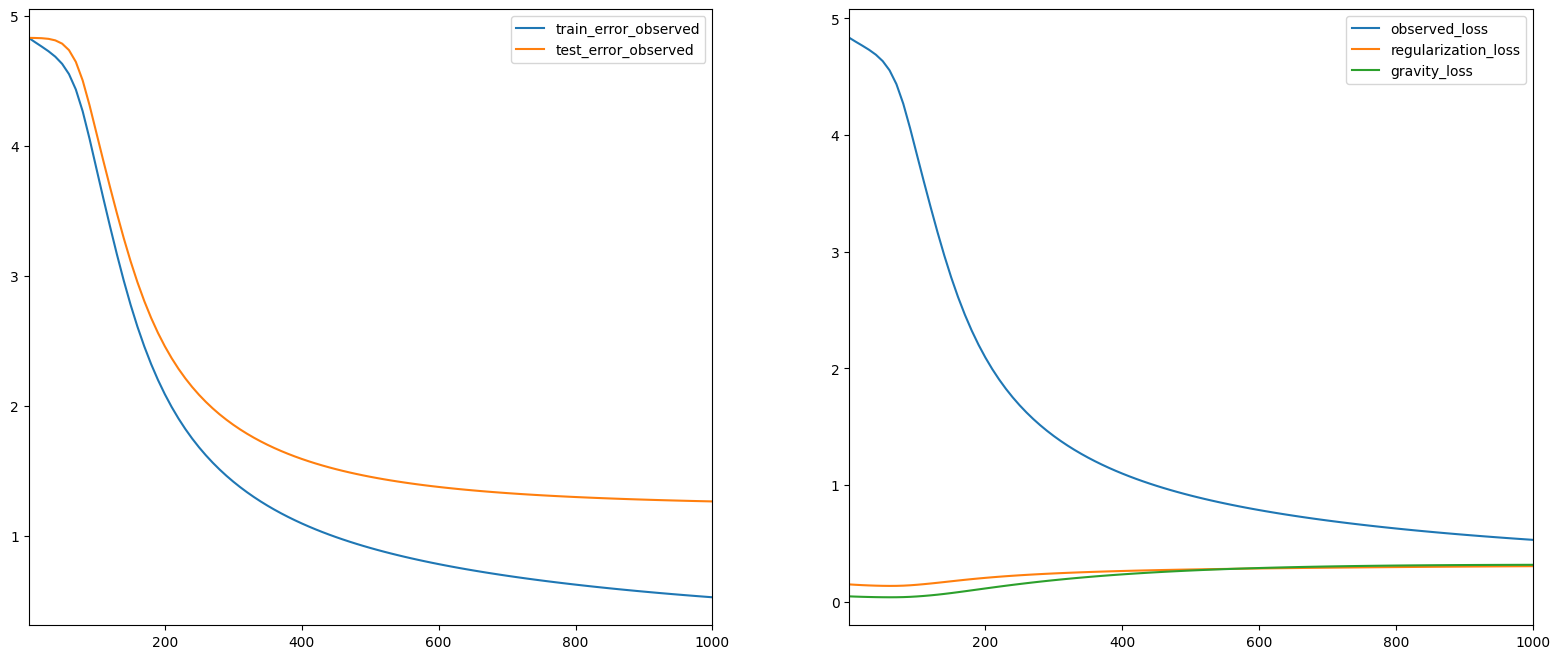

In [ ]:
# We will take the same parameters as before
reg_model = build_regularized_model(ratings_table, regularization_coeff=0.1,
                                    gravity_coeff=1.0, embedding_dim=12,init_stddev=.25)
trained_model = reg_model.train(num_iterations=1000, learning_rate=10.)

We can see that the train and test loss has increased compared to our previous model. But the range between the train and test data is tighter in the regularised model. Meaning that the performance on the both seen and unseen is more consistent for the regularised. This is a good indication that it has not learnt the specifics of the features in the training set and has instead got a high-level view of the data that can better generalise to unseen data.

+ Previous - train_error=0.146221, test_error=1.078422
+ Current - train_error_observed=0.532199, test_error_observed=1.253562

This highlights why regularisation is good for avoiding ovefitting.

We will have a quick look at the artists closest to Eminem and The Beatles as before.

In [ ]:
# query_artist = artists_info[artists_info['name'] == input()]
# query_artist

In [ ]:
rec_regdot = artist_neighbors(reg_model, artists, "System of a Down", measure="dot", k=6)

fig_regdot = go.Figure(
    data = go.Bar(dict(
        x = rec_regdot['name'],
        y = rec_regdot['dotScore'],
        marker=dict(
            color = color_scale
        ),
    )),
    layout = dict(
        template = template,
        xaxis = dict(title = 'Rekomendasi Artis', zeroline=True),
        yaxis = dict(title = 'Skor Dot', zeroline=True),
        title = dict(text = 'Rekomendasi Artis untuk User')
    )
)
fig_regdot.show()

Nearest neighbors of : System of a Down.


,dotScore,name
192,4.747,System of a Down
221,4.593,The Beatles
184,4.571,Muse
1240,4.519,Guns N' Roses
1089,4.508,BjÃ¶rk
492,4.449,Paramore


In [ ]:
rec_regcos = artist_neighbors(reg_model, artists, "System of a Down", measure="cosine", k=6)
fig_regcos = go.Figure(
    data = go.Bar(dict(
        x = rec_regcos['name'],
        y = rec_regcos['cosineScore'],
        marker=dict(
            color = color_scale
        ),
    )),
    layout = dict(
        template = template,
        xaxis = dict(title = 'Rekomendasi Artis', zeroline=True),
        yaxis = dict(title = 'Skor Cosine', zeroline=True),
        title = dict(text = 'Rekomendasi Artis untuk User')
    )
)
fig_regcos.show()

Nearest neighbors of : System of a Down.


,cosineScore,name
192,1.000,System of a Down
700,0.956,AC/DC
1240,0.956,Guns N' Roses
1035,0.946,Slipknot
1095,0.944,Rammstein
214,0.943,Red Hot Chili Peppers


In [ ]:
artist_neighbors(reg_model, artists, "Michael Jackson", measure="dot", k=6)

Nearest neighbors of : Michael Jackson.
[Found more than one matching artist. Other candidates: Michael Jackson & Britney Spears, Michael Jackson & Paul McCartney, Diana Ross, Michael Jackson & Quincy Jones]


,dotScore,name
283,5.829,Britney Spears
83,5.642,Lady Gaga
151,5.612,Michael Jackson
673,5.405,Glee Cast
61,5.390,Madonna
492,5.322,Paramore


,dotScore,name
283,5.829,Britney Spears
83,5.642,Lady Gaga
151,5.612,Michael Jackson
673,5.405,Glee Cast
61,5.390,Madonna
492,5.322,Paramore


In [ ]:
artist_neighbors(reg_model, artists, "Michael Jackson", measure="cosine", k=6)
print('')

Nearest neighbors of : Michael Jackson.
[Found more than one matching artist. Other candidates: Michael Jackson & Britney Spears, Michael Jackson & Paul McCartney, Diana Ross, Michael Jackson & Quincy Jones]


,cosineScore,name
151,1.000,Michael Jackson
3178,0.968,Dangerous Muse
1237,0.963,Panic! At the Disco
224,0.961,Green Day
2526,0.957,Vanessa Carlton
292,0.957,Lily Allen


In [ ]:
user_ratings = ratings_table[ratings_table["userID"] == 72].sort_values(by='implicitRating', ascending=False)
user_ratings

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
56394,72,2081,existâ trace,NaN,NaN,None,3
56236,72,1907,HIGH and MIGHTY COLOR,https://i.scdn.co/image/ab67616d0000b2736a02a6...,https://open.spotify.com/artist/68vPeaQOlnY1aA...,j-metal,3
56397,72,2082,Brown Eyed Girls,https://i.scdn.co/image/ab6761610000e5ebc88f19...,https://open.spotify.com/artist/2GEPtT5RDxrmdi...,k-pop,3
20063,72,361,BIG BANG,https://i.scdn.co/image/ab67616d0000b273d0f23d...,https://open.spotify.com/artist/6hTL6wYjF0b367...,None,3
56391,72,2080,Aira Mitsuki,https://i.scdn.co/image/ab67616d0000b2736d7dde...,https://open.spotify.com/artist/1HeD0mCtcfVGbW...,japanese electropop,3
...,...,...,...,...,...,...,...
53968,72,1848,YUI,https://i.scdn.co/image/ab6761610000e5eb8f1a96...,https://open.spotify.com/artist/5WBO8UyOuJ1l7Z...,j-pop,2
20919,72,382,B2ST,NaN,https://open.spotify.com/artist/2BJRFjk0lXTZCW...,None,2
20244,72,370,UVERworld,https://i.scdn.co/image/ab6761610000e5ebe18fc8...,https://open.spotify.com/artist/6m14xgA0m3w92U...,anime,2
20078,72,363,2PM,https://i.scdn.co/image/ab6761610000e5eb125d29...,https://open.spotify.com/artist/5iRPbkcPmqAFFw...,k-pop,2


In [ ]:
user_rec_regcos = user_recommendations(reg_model, "cosine", 72, artists, exclude_rated=False, k=6)
fig_user_regcos = go.Figure(
    data = go.Bar(dict(
        x = user_rec_regcos['name'],
        y = user_rec_regcos['cosineScore'],
        marker=dict(
            color = color_scale
        ),
    )),
    layout = dict(
        template = template,
        xaxis = dict(title = 'Rekomendasi Artis', zeroline=True),
        yaxis = dict(title = 'Skor Cosine', zeroline=True),
        title = dict(text = 'Rekomendasi Artis untuk User')
    )
)
fig_user_regcos.show()

,cosineScore,artistID,name
11363,0.879,11363,Illa J
10743,0.872,10743,Moenia
8925,0.871,8925,Sum
8901,0.868,8901,Tanghetto
2080,0.867,2080,Aira Mitsuki
15527,0.860,15527,Blackjoy


In [ ]:
user_rec_regdot = user_recommendations(reg_model, "dot", 72, artists, exclude_rated=False, k=6)
fig_user_regdot = go.Figure(
    data = go.Bar(dict(
        x = user_rec_regdot['name'],
        y = user_rec_regdot['dotScore'],
        marker=dict(
            color = color_scale
        ),
    )),
    layout = dict(
        template = template,
        xaxis = dict(title = 'Rekomendasi Artis', zeroline=True),
        yaxis = dict(title = 'Skor Dot', zeroline=True),
        title = dict(text = 'Rekomendasi Artis untuk User')
    )
)
fig_user_regdot.show()

,dotScore,artistID,name
49,3.424,49,Kylie Minogue
369,3.358,369,æµå´ããã¿
61,3.304,61,Madonna
283,3.238,283,Britney Spears
1036,3.180,1036,Fresno
286,3.155,286,Christina Aguilera


### 2.2.3 User recommendation (Rock)

In [ ]:
user_ratings = ratings_table[ratings_table["userID"] == 808].sort_values(by='implicitRating', ascending=False)
user_ratings

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
33326,808,701,Metallica,https://i.scdn.co/image/ab6761610000e5eb69ca98...,https://open.spotify.com/artist/2ye2Wgw4gimLv2...,hard rock,3
71967,808,5114,Enrique Bunbury,NaN,https://open.spotify.com/artist/170cTXuqu7GtSm...,None,3
45559,808,1207,Mastodon,https://i.scdn.co/image/ab6761610000e5ebf84fe9...,https://open.spotify.com/artist/1Dvfqq39HxvCJ3...,alternative metal,3
44259,808,1122,Tool,https://i.scdn.co/image/ab6761610000e5eb13f547...,https://open.spotify.com/artist/2yEwvVSSSUkcLe...,alternative metal,3
43958,808,1109,A Perfect Circle,https://i.scdn.co/image/ab6761610000e5eb414725...,https://open.spotify.com/artist/4DFhHyjvGYa9wx...,alternative metal,3
...,...,...,...,...,...,...,...
38484,808,908,Iron Maiden,https://i.scdn.co/image/ab6761610000e5eb6456e7...,https://open.spotify.com/artist/6mdiAmATAx73kd...,hard rock,2
38722,808,911,Dream Theater,https://i.scdn.co/image/ab6761610000e5eb881f3d...,https://open.spotify.com/artist/2aaLAng2L2aWD2...,hard rock,2
40208,808,962,ZoÃ©,NaN,NaN,None,2
40550,808,973,Foo Fighters,https://i.scdn.co/image/ab6761610000e5ebc884df...,https://open.spotify.com/artist/7jy3rLJdDQY21O...,alternative metal,2


#### userID 711 (Rock)

In [ ]:
user_recommendations(reg_model, "dot", 711, artists, exclude_rated=False, k=6)
print('')


user_recommendations(matrix_fac, "dot", 711, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
1663,2.248,1663,Avenged Sevenfold
1035,2.123,1035,Slipknot
492,2.114,492,Paramore
807,2.105,807,A Day to Remember
371,2.104,371,Linkin Park
1089,2.097,1089,BjÃ¶rk


,dotScore,artistID,name
3438,2.470,3438,Wolfmother
1975,2.462,1975,Fever Ray
3304,2.416,3304,Motion City Soundtrack
6691,2.409,6691,Ted Leo and The Pharmacists
4718,2.387,4718,Forfun
3184,2.386,3184,Biquini CavadÃ£o


In [ ]:
user_recommendations(reg_model, "cosine", 711, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "cosine", 711, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
486,0.958,486,Funeral for a Friend
807,0.947,807,A Day to Remember
1035,0.929,1035,Slipknot
2047,0.917,2047,In This Moment
1173,0.915,1173,The Red Jumpsuit Apparatus
3829,0.913,3829,Jorge Drexler


,cosineScore,artistID,name
4722,0.948,4722,Mest
1039,0.941,1039,The Kooks
426,0.937,426,Klaxons
1701,0.931,1701,Therion
1973,0.926,1973,The Subways
3304,0.922,3304,Motion City Soundtrack


#### userID 808 (Rock)

In [ ]:
user_recommendations(reg_model, "cosine", 808, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "cosine", 808, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
3612,0.928,3612,Why?
3354,0.921,3354,Zeca Baleiro
4039,0.921,4039,Mike Oldfield
2409,0.920,2409,The New Pornographers
3619,0.915,3619,Elle Milano
4232,0.912,4232,Tricky


,cosineScore,artistID,name
10239,0.932,10239,Parque En El Espacio
15469,0.930,15469,Spade Cooley
13666,0.923,13666,Gripin
2011,0.906,2011,The Residents
874,0.901,874,Tiamat
866,0.900,866,Bauhaus


In [ ]:
user_recommendations(reg_model, "dot", 808, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "dot", 808, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
227,2.964,227,Nine Inch Nails
701,2.714,701,Metallica
430,2.709,430,The Smashing Pumpkins
220,2.625,220,Queens of the Stone Age
146,2.595,146,Porcupine Tree
911,2.554,911,Dream Theater


,dotScore,artistID,name
5809,3.464,5809,Bonde do RolÃª
3816,3.359,3816,Soda Stereo
3346,3.330,3346,Victor e Leo
1181,3.305,1181,We Are The Ocean
2135,3.289,2135,Fightstar
66,3.287,66,Depeche Mode


### 2.2.4 User recommendation (Pop)

In [ ]:
user_ratings = ratings_table[ratings_table["userID"] == 15].sort_values(by='implicitRating', ascending=False).reset_index(drop=True)
user_ratings

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
0,15,673,Glee Cast,https://i.scdn.co/image/5b5a95f260ac429405e871...,https://open.spotify.com/artist/0SCbttzoZTnLFe...,glee club,4
1,15,83,Lady Gaga,https://i.scdn.co/image/ab6761610000e5ebc8d3d9...,https://open.spotify.com/artist/1HY2Jd0NmPuamS...,art pop,3
2,15,542,Ellie Goulding,https://i.scdn.co/image/ab6761610000e5eb854b61...,https://open.spotify.com/artist/0X2BH1fck6amBI...,indietronica,3
3,15,294,Katy Perry,https://i.scdn.co/image/ab6761610000e5ebdc9dcb...,https://open.spotify.com/artist/6jJ0s89eD6GaHl...,pop,3
4,15,492,Paramore,https://i.scdn.co/image/ab6761610000e5ebb10c34...,https://open.spotify.com/artist/74XFHRwlV6OrjE...,candy pop,3
...,...,...,...,...,...,...,...
45,15,522,Pixie Lott,https://i.scdn.co/image/ab6761610000e5eb9f9103...,https://open.spotify.com/artist/3EBRANWwnViQuB...,dance pop,2
46,15,532,Maroon 5,https://i.scdn.co/image/ab6761610000e5ebf8349d...,https://open.spotify.com/artist/04gDigrS5kc9YW...,pop,2
47,15,538,Adam Lambert,https://i.scdn.co/image/ab6761610000e5eb28db24...,https://open.spotify.com/artist/6prmLEyn4LfHlD...,dance pop,2
48,15,61,Madonna,https://i.scdn.co/image/ab6761610000e5eb4b36d2...,https://open.spotify.com/artist/6tbjWDEIzxoDsB...,dance pop,2


#### userID 15 (POP)

In [ ]:
user_recommendations(reg_model, "cosine", 15, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "cosine", 15, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
673,0.966,673,Glee Cast
5859,0.939,5859,Semi Precious Weapons
338,0.936,338,Taylor Swift
793,0.933,793,AnahÃ­
455,0.932,455,Miley Cyrus
292,0.926,292,Lily Allen


,cosineScore,artistID,name
3534,0.978,3534,Jason Aldean
1025,0.938,1025,Kerli
13533,0.938,13533,Antischism
1374,0.931,1374,Imogen Heap
7681,0.920,7681,Charice
2967,0.919,2967,HEVO84


In [ ]:
user_recommendations(reg_model, "dot", 15, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "dot", 15, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
673,2.665,673,Glee Cast
283,2.610,283,Britney Spears
338,2.545,338,Taylor Swift
83,2.509,83,Lady Gaga
455,2.427,455,Miley Cyrus
286,2.383,286,Christina Aguilera


,dotScore,artistID,name
2833,2.832,2833,Thin Lizzy
518,2.808,518,Jeffree Star
2285,2.796,2285,Ezginin GÃ¼nlÃ¼ÄÃ¼
369,2.793,369,æµå´ããã¿
1025,2.773,1025,Kerli
449,2.763,449,Backstreet Boys


#### userID 44 (POP)

In [ ]:
user_recommendations(reg_model, "cosine", 44, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "cosine", 44, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
455,0.976,455,Miley Cyrus
2781,0.973,2781,High School Musical
286,0.961,286,Christina Aguilera
380,0.959,380,Cascada
784,0.952,784,Hannah Montana
4704,0.952,4704,Natalia Kills


,cosineScore,artistID,name
1029,0.957,1029,The Maine
899,0.957,899,Vanessa Hudgens
273,0.955,273,Brandy
788,0.952,788,Emily Osment
455,0.941,455,Miley Cyrus
458,0.939,458,3OH!3


In [ ]:
user_recommendations(reg_model, "dot", 44, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "dot", 44, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
283,3.023,283,Britney Spears
286,2.744,286,Christina Aguilera
455,2.652,455,Miley Cyrus
282,2.568,282,Rihanna
673,2.554,673,Glee Cast
452,2.554,452,Justin Bieber


,dotScore,artistID,name
283,2.914,283,Britney Spears
629,2.690,629,Teen Angels
83,2.664,83,Lady Gaga
286,2.652,286,Christina Aguilera
4472,2.601,4472,Amerie
673,2.574,673,Glee Cast


### 2.2.5 User recommendations (KPOP)

In [ ]:
user_ratings = ratings_table[ratings_table["Tag"] == "k-pop"].sort_values(by='implicitRating', ascending=False)
user_ratings

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
56216,914,1894,SHINee,https://i.scdn.co/image/ab6761610000e5ebe0001b...,https://open.spotify.com/artist/2hRQKC0gqlZGPr...,k-pop,4
56364,1000,2079,BoA,https://i.scdn.co/image/ab6761610000e5eb1b8665...,https://open.spotify.com/artist/4muJrGMndyYWqZ...,k-pop,3
56362,948,2079,BoA,https://i.scdn.co/image/ab6761610000e5eb1b8665...,https://open.spotify.com/artist/4muJrGMndyYWqZ...,k-pop,3
56361,942,2079,BoA,https://i.scdn.co/image/ab6761610000e5eb1b8665...,https://open.spotify.com/artist/4muJrGMndyYWqZ...,k-pop,3
56358,816,2079,BoA,https://i.scdn.co/image/ab6761610000e5eb1b8665...,https://open.spotify.com/artist/4muJrGMndyYWqZ...,k-pop,3
...,...,...,...,...,...,...,...
56363,990,2079,BoA,https://i.scdn.co/image/ab6761610000e5eb1b8665...,https://open.spotify.com/artist/4muJrGMndyYWqZ...,k-pop,2
21233,213,403,G-Dragon,https://i.scdn.co/image/ab6761610000e5eb5923c0...,https://open.spotify.com/artist/30b9WulBM8sFuB...,k-pop,2
56365,1024,2079,BoA,https://i.scdn.co/image/ab6761610000e5eb1b8665...,https://open.spotify.com/artist/4muJrGMndyYWqZ...,k-pop,2
20078,72,363,2PM,https://i.scdn.co/image/ab6761610000e5eb125d29...,https://open.spotify.com/artist/5iRPbkcPmqAFFw...,k-pop,2


In [ ]:
user_ratings = ratings_table[ratings_table["userID"] == 914].sort_values(by='implicitRating', ascending=False)
user_ratings

,userID,artistID,name,imageUrl,spotifyUrl,Tag,implicitRating
18769,914,327,Avril Lavigne,https://i.scdn.co/image/ab6761610000e5eb581efa...,https://open.spotify.com/artist/0p4nmQO2msCgU4...,canadian pop,5
56216,914,1894,SHINee,https://i.scdn.co/image/ab6761610000e5ebe0001b...,https://open.spotify.com/artist/2hRQKC0gqlZGPr...,k-pop,4
85077,914,11299,B1A4,https://i.scdn.co/image/ab6761610000e5ebb91b9e...,https://open.spotify.com/artist/3sxWOFw4MSN54S...,k-pop,3
85078,914,11300,ì¥ê·¼ì,https://i.scdn.co/image/ab6761610000e5eb0234b1...,https://open.spotify.com/artist/2NjfBq1NflQcKS...,australian pop,3
85079,914,11301,ë¯¼í¸,https://i.scdn.co/image/ab6761610000e5eb0234b1...,https://open.spotify.com/artist/2NjfBq1NflQcKS...,australian pop,3
...,...,...,...,...,...,...,...
37637,914,889,Tegan and Sara,https://i.scdn.co/image/ab6761610000e5ebb6517a...,https://open.spotify.com/artist/5e1BZulIiYWPRm...,canadian indie,2
53975,914,1848,YUI,https://i.scdn.co/image/ab6761610000e5eb8f1a96...,https://open.spotify.com/artist/5WBO8UyOuJ1l7Z...,j-pop,2
55833,914,2025,Luciano Pavarotti,https://i.scdn.co/image/ab6761610000e5eb7c79a2...,https://open.spotify.com/artist/0Y8KmFkKOgJybp...,canzone napoletana,2
56272,914,2074,í°ìë¼,https://i.scdn.co/image/ab6761610000e5eb0234b1...,https://open.spotify.com/artist/2NjfBq1NflQcKS...,australian pop,2


#### userID 105 (KPOP)

In [ ]:
user_recommendations(reg_model, "cosine", 213, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "cosine", 213, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
2074,0.915,2074,í°ìë¼
4525,0.896,4525,Jazmine Sullivan
10352,0.885,10352,Lesley Roy
394,0.878,394,2NE1
900,0.878,900,Delta Goodrem
251,0.877,251,Mariah Carey


,cosineScore,artistID,name
3362,0.946,3362,Plastiscines
1023,0.928,1023,Jessie J
9001,0.926,9001,Lasgo
478,0.923,478,Ne-Yo
286,0.917,286,Christina Aguilera
394,0.915,394,2NE1


In [ ]:
# FOR USER 105 KPOP FANS
user_recommendations(reg_model, "dot", 213, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "dot", 213, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
251,3.075,251,Mariah Carey
283,3.010,283,Britney Spears
286,2.998,286,Christina Aguilera
282,2.920,282,Rihanna
49,2.822,49,Kylie Minogue
695,2.802,695,Shakira


,dotScore,artistID,name
283,3.265,283,Britney Spears
286,3.091,286,Christina Aguilera
3356,2.979,3356,Sandy Leah
317,2.885,317,The Saturdays
282,2.869,282,Rihanna
4472,2.866,4472,Amerie


#### userID 72 (KPOP)

In [ ]:
user_recommendations(reg_model, "cosine", 72, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "cosine", 72, artists, exclude_rated=False, k=6)
print('')

,cosineScore,artistID,name
11363,0.879,11363,Illa J
10743,0.872,10743,Moenia
8925,0.871,8925,Sum
8901,0.868,8901,Tanghetto
2080,0.867,2080,Aira Mitsuki
15527,0.860,15527,Blackjoy


,cosineScore,artistID,name
10336,0.895,10336,Joni James
6425,0.875,6425,Diddy
17491,0.870,17491,é»æ°ã°ã«ã¼ã´
3450,0.860,3450,ã¢ã³ã¸ã§ã©ã»ã¢ã­
14660,0.858,14660,Rebecca Caine
3104,0.857,3104,We Are the Fallen


In [ ]:
user_recommendations(reg_model, "dot", 72, artists, exclude_rated=False, k=6)
print('')
user_recommendations(matrix_fac, "dot", 72, artists, exclude_rated=False, k=6)
print('')

,dotScore,artistID,name
49,3.424,49,Kylie Minogue
369,3.358,369,æµå´ããã¿
61,3.304,61,Madonna
283,3.238,283,Britney Spears
1036,3.180,1036,Fresno
286,3.155,286,Christina Aguilera


,dotScore,artistID,name
3104,3.817,3104,We Are the Fallen
5305,3.586,5305,AndrÃ© ValadÃ£o
791,3.580,791,Atomic Kitten
3356,3.549,3356,Sandy Leah
2454,3.544,2454,Peter Gabriel
629,3.497,629,Teen Angels


### 2.2.6 Misc (Indie)

In [ ]:
artist_neighbors(reg_model, artists, "Sufjan Steven", measure="cosine", k=6)
print('')

Nearest neighbors of : Sufjan Stevens.


,cosineScore,name
616,1.000,Sufjan Stevens
219,0.962,Interpol
196,0.960,CAKE
1501,0.953,Black Rebel Motorcycle Club
1624,0.945,Fleet Foxes
703,0.938,The White Stripes


It can be seen that the dot product for Eminem returns many popular artists, likely due to the large norm they have. The cosine similarity recommendations seem more relevant with Kid Cudi being a rapper.

For The Beatles, both sets of recommendations seem relevant with The Beach Boys, Bob Dylan, Kings of Leon, Red Hot Chili Peppers and The Killers all being neighbours.

## 2.7 Conclusion

I have found creating these models quite interesting. It is difficult at first to fit the components together in Tensorflow, but as I have gone through training these models I have got a better grasp.

I had hoped to have a look at using the user releationships to get more information from the data but I was unsure how I could plug them in.

I wanted to try and create a representation of the users friend group by getting the average of all of the friend latent representations. My understanding would be that the user will be influenced by all these friends in the direction of that vector.

I have definitely become more familiar with using Tensorflow and have got a better grasp of what considerations there are for building a recommender.

# Section 3 - New User Recommendations

We will make use of Streamlit to create a webpage for entering artists and listening scores. This can then be used to create a full user vector.

Taking this with the item-matrix gives us an approxiamte latent representation of the user vector. With this we can compute the recommendations for a user. We will take the basic model

In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.8 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19580 sha256=a1e94c573be37253383b01ee20c7530939145d8d2f7889cfa1cfba317e78db57
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzloca

In [ ]:
!pip install protobuf --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


## 3.1 Streamlit GUI

I will be making use of some of a streamlit application that I have made before with some tweaks to display the information we want.

We will need to save the artist embeddings and the list of all artists and their ids. This will have to be done following the same technique use in data preperation so that the IDs match between the embeddings and the item dictionary.

In [ ]:
# from CFUtils import build_rating_sparse_tensor, split_dataframe, sparse_mean_square_error, build_model, CFModel, user_recommendations, compute_scores, artist_neighbors, gravity, build_regularized_model
# import sklearn
# import tensorflow.compat.v1 as tf

In [ ]:
import pickle
import streamlit as st
from pyngrok import ngrok

# Setup a tunnel to the streamlit port 8501
!ngrok authtoken 2Re8bMddlvChHlzWDMNxBw1oC0g_46XV18KS8pqaXi512t4P9
# ngrok.set_auth_token('2Re8bMddlvChHlzWDMNxBw1oC0g_46XV18KS8pqaXi512t4P9')

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# artist_embeddings = matrix_fac.embeddings["artistID"]

In [ ]:
artist_embeddings = reg_model.embeddings["artistID"]

In [ ]:
ratings_table = full_user_artists.copy()

In [ ]:
ratings_table.sample(15)

,userID,artistID,weight,name,genres,imageUrl,spotifyUrl
5265,184,166,138,The Cranberries,"['irish rock', 'pop rock', 'rock']",https://i.scdn.co/image/143c01f407ed64a4b3bcbc...,https://open.spotify.com/artist/7t0rwkOPGlDPEh...
51284,1593,1596,894,Christina Milian,"['dance pop', 'hip pop', 'post-teen pop', 'r&b...",https://i.scdn.co/image/f5463b27334e1743de80eb...,https://open.spotify.com/artist/4eAOcbAXIF4Bmb...
73777,338,5837,218,æµç°éº»é,[],NaN,NaN
92469,2027,18313,154,Anthem Lights,"['channel pop', 'viral pop']",https://i.scdn.co/image/ab6761610000e5ebba26ca...,https://open.spotify.com/artist/7kwEvDE8e7EBGK...
54744,1975,1946,335,Madlib,"['abstract hip hop', 'alternative hip hop', 'h...",https://i.scdn.co/image/ab6761610000e5ebdb860c...,https://open.spotify.com/artist/5LhTec3c7dcqBv...
...,...,...,...,...,...,...,...
86838,1187,12999,169,New Shouts,[],https://i.scdn.co/image/ab67616d0000b273884504...,https://open.spotify.com/artist/5ZqH9WFFL6RBNZ...
38409,178,917,1227,Iron Maiden,"['hard rock', 'metal', 'nwobhm', 'rock']",https://i.scdn.co/image/ab6761610000e5eb6456e7...,https://open.spotify.com/artist/6mdiAmATAx73kd...
54865,488,1958,139,The Flaming Lips,"['alternative rock', 'chamber pop', 'indie roc...",https://i.scdn.co/image/ab6761610000e5ebbaf865...,https://open.spotify.com/artist/16eRpMNXSQ15wu...
80180,618,8630,69,"ÐÐ¸ÑÐµÐº, ÐÐºÑÑÑÐ¸Ðº, ÐÐ¶Ð¾ÑÐ´Ð°Ð½ Ð¡Ð...",[],NaN,NaN


In [ ]:
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
old_column = ratings_table["artistID"].values
old_new_mapping = {k:v for k, v in zip(old_column, new_column)}

ratings_table["artistID"] = new_column

In [ ]:
artist_dict = {k: v for k, v in ratings_table[["artistID", "name"]].values}

In [ ]:
artist_info = artists_info.copy().reset_index(drop=True)
artist_info

,artistID,name,imageUrl,spotifyUrl,Tag
0,0,MALICE MIZER,NaN,NaN,None
1,1,Diary of Dreams,https://i.scdn.co/image/ab6761610000e5eb332690...,https://open.spotify.com/artist/1tg5jMp8FFjVqj...,dark wave
2,2,Carpathian Forest,https://i.scdn.co/image/ab67616d0000b2736b4987...,https://open.spotify.com/artist/0sFntmE9T1tiF6...,black metal
3,3,Moi dix Mois,https://i.scdn.co/image/ab67616d0000b273bba816...,https://open.spotify.com/artist/0p127CcuzngV5R...,None
4,4,Bella Morte,https://i.scdn.co/image/ab6761610000e5eb9b15fc...,https://open.spotify.com/artist/2SyimynlSU0Oii...,corrosion
...,...,...,...,...,...
17627,17627,Diamanda GalÃ¡s,NaN,NaN,None
17628,17628,Aya RL,https://i.scdn.co/image/ab67616d0000b27327c22a...,https://open.spotify.com/artist/3qZ0S1nVG3Pcct...,polish post-punk
17629,17629,Coptic Rain,NaN,https://open.spotify.com/artist/3GrTeFVsVk1fKB...,None
17630,17630,Oz Alchemist,https://i.scdn.co/image/ab6761610000e5ebcbd754...,https://open.spotify.com/artist/7tt8Fc1yW2t9SC...,None


In [ ]:
with open('drive/MyDrive/CA4015/embeddings.pickle', 'wb') as p:
  pickle.dump(artist_embeddings, p, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('drive/MyDrive/CA4015/artists.pickle', 'wb') as p:
  pickle.dump(artist_dict, p, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('drive/MyDrive/CA4015/trained_model.pickle', 'wb') as p:
  pickle.dump(trained_model, p, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('drive/MyDrive/CA4015/artists_info.pickle', 'wb') as p:
  pickle.dump(artist_info, p, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('drive/MyDrive/CA4015/embeddings.pickle', 'rb') as file:
#       data = pickle.load(file)
# print(data)
# plt.imshow(data, cmap='viridis')
# plt.colorbar()
# plt.show()

In [ ]:
with open('drive/MyDrive/CA4015/artists.pickle', 'rb') as file:
      data = pickle.load(file)
print(data)

In [ ]:
with open('drive/MyDrive/CA4015/trained_model.pickle', 'rb') as file:
  data = pickle.load(file)
print(data)

### Streamlit file

The streamlit file can be found [here](https://github.com/teg-lad/CA4015-LastFM-Recommender) in the git repository for this assignment.

It will load the embedding and load the artists.

The user can select what artist they would like to rate from a dropdown. They can then proceed to rate the artists, preferably by using the range outlined earlier.

+ 0 - A user has not listened to an artist
+ 1 - A user has listened to an artist once
+ 2 - A user has listened to an artist 2-1000 times
+ 3 - A user has listened to an artist 1001-10000 times
+ 4 - A user has listened to an artist 10001-50000 times
+ 5 - A user has listened to an artist 50000+ times

Once the user select compute recommendation, the ratings are turned into a sparse vector, multiplied by the artist embeddings to get the appoximate user embedding and then by the transpose of the artist embeddings to get the recommendations.



In [ ]:
!streamlit run --server.port 8501 recommender.py &>/dev/null&

In [ ]:
# Check that streamlit is running
!pgrep streamlit

In [ ]:
# Start the ngrok tunnel
# public_url = ngrok.connect(addr="localhost:8501")
public_url = ngrok.connect(addr="localhost:8501")
# public_url = ngrok.connect(port='8501')
# Print the public URL
print("Public URL:", public_url)

In [ ]:
# # RUN INCASE OTHER TUNNEL IS ONLINE
# tunnels = ngrok.get_tunnels()

# # Stop each tunnel
# for tunnel in tunnels:
#     ngrok.disconnect(tunnel.public_url)

# # Confirm that the tunnels have been stopped
# print("Existing tunnels stopped.")

* The code loads pre-trained artist embeddings and a dictionary mapping artist IDs to their names.

* The sparse_list() function takes the user ratings as input and converts them into a sparse list representation. It assigns the user ratings to the corresponding positions in the list, based on the artist IDs. If an artist ID is not found in the ratings, it is added to the not_found list.

* The compute_recommendations() function takes the sparse list of user ratings and artist ID-name dictionary as input. It converts the sparse list into a numpy array of ratings. It then performs matrix multiplication to compute the latent representation of the user's ratings by multiplying the ratings array with the artist embeddings. The recommendations are calculated by multiplying the latent representation with the transpose of the artist embeddings.

* In the main() function, the user can select artists and rate them using a multi-select and select box interface. The selected artists and their ratings are stored in the user_listens dictionary.

* If the user has rated at least one artist, the compute_recommendations() function is called with the user_listens and artist ID-name dictionary. The recommendations are displayed in a DataFrame, sorted by the "Predicted relevance" column.

*Matrix factorization is a technique used in collaborative filtering to decompose the user-item rating matrix into two lower-dimensional matrices representing user and item latent factors. The code provided uses matrix factorization to compute recommendations based on the user's ratings and the pre-trained artist embeddings.